In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import tkinter as tk
from tkinter import ttk
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from scipy.sparse import issparse

In [2]:
# Load datasets
df1 = pd.read_csv("pdb_data_no_dups.csv")
df2 = pd.read_csv("pdb_data_seq.csv")

# Filter df1 to keep only classes with >=50 samples and top 10 classes
top_classes = df1['classification'].value_counts()
frequent_classes = top_classes[top_classes >= 50].index[:4]  # Top 4 classes
df1_filtered_classes = df1[df1['classification'].isin(frequent_classes)]

print(f"Reduced from {df1['classification'].nunique()} to {len(frequent_classes)} classes")
print(f"Dataset size after filtering classes: {len(df1_filtered_classes)} samples")

# Sample 50% of the filtered df1 and df2
sampled_df1 = df1_filtered_classes.sample(frac=0.5, random_state=42)
sampled_df2 = df2.sample(frac=0.5, random_state=42)

# Select required columns and rename residueCount in df1
df1_filtered = sampled_df1[["structureId", "classification", "macromoleculeType", "residueCount", "resolution"]]
df1_filtered = df1_filtered.rename(columns={
    "residueCount": "residueCount_df1",
    "macromoleculeType": "macromoleculeType_df1"
})

# Select required columns and rename residueCount in df2
df2_filtered = sampled_df2[["structureId", "sequence", "residueCount"]]
df2_filtered = df2_filtered.rename(columns={"residueCount": "residueCount_df2"})

# Merge on structureId
merged_df = pd.merge(df1_filtered, df2_filtered, on="structureId", how="inner")

# Save the filtered & merged dataset
merged_df.to_csv("filtered_dataset.csv", index=False)

print(f"Filtered dataset saved as filtered_dataset.csv with {len(merged_df)} rows.")


Reduced from 5050 to 4 classes
Dataset size after filtering classes: 53515 samples
Filtered dataset saved as filtered_dataset.csv with 33266 rows.


In [3]:
# === Drop duplicate sequences ===
merged_df = merged_df.drop_duplicates(subset="sequence")

# Drop rows where any column has a missing value
merged_df = merged_df.dropna()

# === Save the final filtered dataset ===
merged_df.to_csv("filtered_dataset.csv", index=False)

print(f"Filtered dataset saved as filtered_dataset.csv with {len(merged_df)} rows.")

Filtered dataset saved as filtered_dataset.csv with 13823 rows.


In [4]:
# Function to split sequences into overlapping k-mers
def get_kmers(sequence, k=3):
    return ' '.join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

# Apply k-mer transformation to the sequence column in merged_df
merged_df['kmers'] = merged_df['sequence'].apply(lambda x: get_kmers(x, k=3))

# Vectorize the k-mers into numeric features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(merged_df['kmers'])

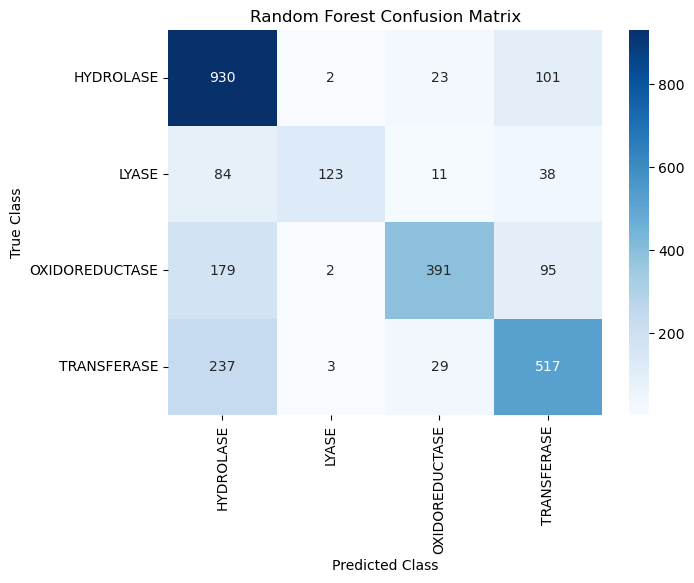

Accuracy: 70.92%

Classification Report:
                precision    recall  f1-score   support

     HYDROLASE       0.65      0.88      0.75      1056
         LYASE       0.95      0.48      0.64       256
OXIDOREDUCTASE       0.86      0.59      0.70       667
   TRANSFERASE       0.69      0.66      0.67       786

      accuracy                           0.71      2765
     macro avg       0.79      0.65      0.69      2765
  weighted avg       0.74      0.71      0.70      2765



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Target variable
y = merged_df['classification']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=0)

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Random Forest Confusion Matrix')
plt.show()


# Print results
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(class_report)


In [6]:
# --- Step 1: K-mer transformation ---
def get_kmers(sequence, k=3):
    return ' '.join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

merged_df['kmers'] = merged_df['sequence'].apply(lambda x: get_kmers(x, k=3))

# --- Step 2: Tokenize k-mers (convert to integers) ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged_df['kmers'])
X_seq = tokenizer.texts_to_sequences(merged_df['kmers'])

# Pad sequences so they have the same length
max_length = max(len(seq) for seq in X_seq)
X_seq = pad_sequences(X_seq, maxlen=max_length, padding='post')

# --- Step 3: Encode labels ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(merged_df['classification'])

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# --- Step 5: Build CNN model ---
vocab_size = len(tokenizer.word_index) + 1  # number of unique k-mers
embedding_dim = 50  # size of embedding vector

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# --- Step 6: Train model ---
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# --- Step 7: Evaluate ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.4f}%")


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 71s 197ms/step - accuracy: 0.4266 - loss: 1.2297 - val_accuracy: 0.5494 - val_loss: 1.0550
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 200ms/step - accuracy: 0.6990 - loss: 0.8000 - val_accuracy: 0.6788 - val_loss: 0.8105
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - accuracy: 0.9000 - loss: 0.3419 - val_accuracy: 0.7262 - val_loss: 0.6908
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 200ms/step - accuracy: 0.9714 - loss: 0.1436 - val_accuracy: 0.7400 - val_loss: 0.7772
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 195ms/step - accuracy: 0.9863 - loss: 0.0896 - val_accuracy: 0.7342 - val_loss: 0.8616
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 65s 187ms/step - accuracy: 0.9903 - loss: 0.0717 - val_accuracy: 0.7349 - val_loss: 0.8304
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 194ms/step - accuracy: 0.9912 - loss: 0.0541 - val_accuracy: 0.7248 - val_loss: 0.9858
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 193ms/step - accuracy: 0.9925 - loss: 0

87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step

Class Distribution Comparison:
                True Count  Predicted Count  True %  Predicted %
HYDROLASE             1056             1530   38.19        55.33
LYASE                  256              175    9.26         6.33
OXIDOREDUCTASE         667              497   24.12        17.97
TRANSFERASE            786              563   28.43        20.36


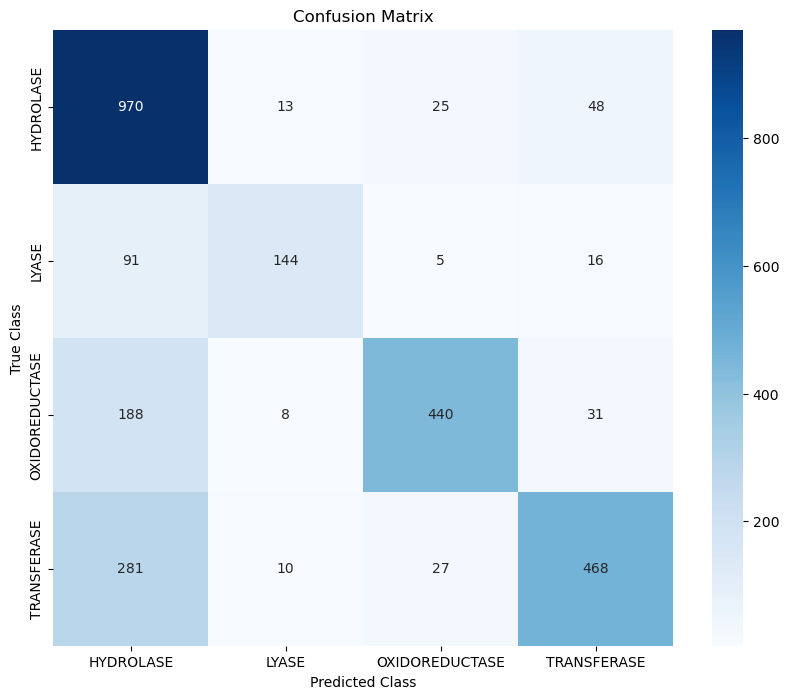


Classification Report:
                 precision    recall  f1-score   support

     HYDROLASE       0.63      0.92      0.75      1056
         LYASE       0.82      0.56      0.67       256
OXIDOREDUCTASE       0.89      0.66      0.76       667
   TRANSFERASE       0.83      0.60      0.69       786

      accuracy                           0.73      2765
     macro avg       0.79      0.68      0.72      2765
  weighted avg       0.77      0.73      0.73      2765



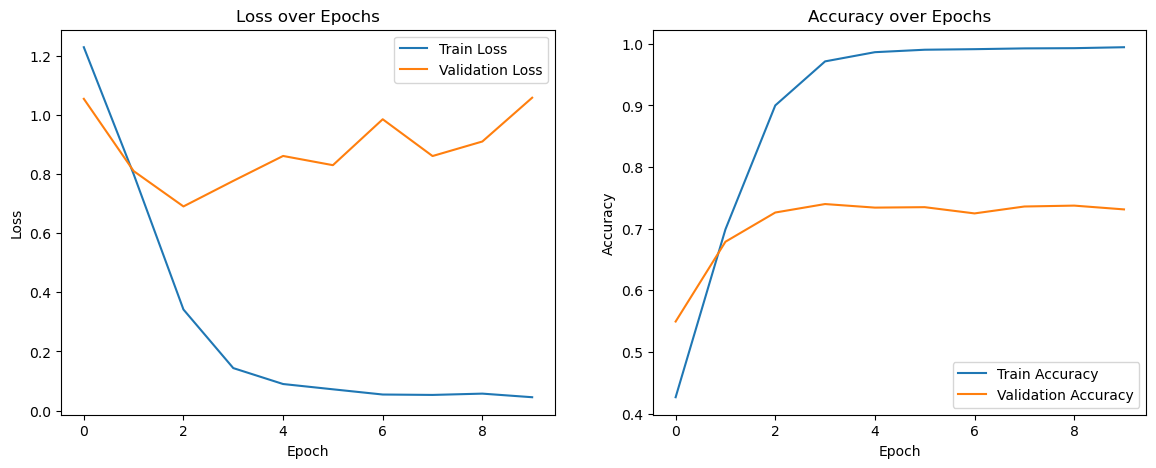


Final Test Accuracy: 73.13%
Final Test Loss: 1.0588


In [16]:
from scipy.sparse import issparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Step 7a: Predict classes for X_test ---
# Convert X_test if sparse
if issparse(X_test):
    X_test_fixed = X_test.toarray()
else:
    X_test_fixed = X_test

y_pred_probs = model.predict(X_test_fixed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Map encoded labels back to original class names
class_names = label_encoder.classes_
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Create a human-readable distribution comparison
true_counts = pd.Series(y_test_labels).value_counts().sort_index()
pred_counts = pd.Series(y_pred_labels).value_counts().sort_index()

distribution_df = pd.DataFrame({
    "True Count": true_counts,
    "Predicted Count": pred_counts
}).fillna(0).astype(int)

# Add percentage columns
distribution_df["True %"] = (distribution_df["True Count"] / len(y_test_labels) * 100).round(2)
distribution_df["Predicted %"] = (distribution_df["Predicted Count"] / len(y_pred_labels) * 100).round(2)

print("\nClass Distribution Comparison:")
print(distribution_df)

# --- Step 7b: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# --- Step 7c: Classification Report ---
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)

# --- Step 7d: Plot Loss and Accuracy Curves ---
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

# --- Step 7e: Final Metrics Summary ---
print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")


In [17]:
def get_kmers(sequence, k=3):
    if len(sequence) < k:
        raise ValueError(f"Sequence length must be at least {k} for k-mer extraction.")
    return ' '.join([sequence[i:i+k] for i in range(len(sequence) - k + 1)])

def predict_protein_class():
    def on_submit():
        user_sequence = text_entry.get("1.0", "end-1c").upper()
        valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
        try:
            if not user_sequence:
                raise ValueError("Empty input is not allowed.")
            if any(aa not in valid_amino_acids for aa in user_sequence):
                raise ValueError("Sequence contains invalid characters. Use only standard amino acid letters (ACDEFGHIKLMNPQRSTVWY).")

            user_kmers = get_kmers(user_sequence, k=3)
            seq = tokenizer.texts_to_sequences([user_kmers])

            max_len = 100  # same as training
            padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')

            prediction_probs = model.predict(padded_seq)
            predicted_class_index = prediction_probs.argmax(axis=1)[0]
            predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

            result_var.set(f"This protein belongs to: {predicted_label}")
        except ValueError as ve:
            result_var.set(f"Input Error: {ve}")
        except Exception as e:
            result_var.set(f"Unexpected error: {e}")

    # Create main window
    root = tk.Tk()
    root.title("GeneCheck")
    root.geometry("500x400")  # Width x Height in pixels

    # Label
    label = ttk.Label(root, text="Enter a protein sequence:")
    label.pack(pady=(10, 5))

    # Text box for sequence input (multi-line, bigger input area)
    text_entry = tk.Text(root, height=6, width=50, font=("Consolas", 12))
    text_entry.pack(pady=(0, 10))

    # Button to submit
    submit_btn = ttk.Button(root, text="Predict", command=on_submit)
    submit_btn.pack()

    # Label to show prediction or error message
    result_var = tk.StringVar()
    result_label = ttk.Label(root, textvariable=result_var, font=("Arial", 14), foreground="blue")
    result_label.pack(pady=(20, 10))

    root.mainloop()

# Call the function to open the GUI
predict_protein_class()